# Data Modelling for Medium Size Bikes & Cycling Accessories Organization
> This project was done under the umbrella of KPMG internship experience. I was provided data sets of an organization targeting a client who wants a feedback from us on their dataset quality and how this can be improved.

### Background
- Sprocket Central Pty Ltd, a medium size bikes & cycling accessories organisation
- needs help with its customer and transactions data
- how to analyse it to help optimise its marketing strategy effectively.

### Datasets
- New Customer List
- Customer Demographic
- Customer Addresses
- Transactions data in the past 3 months
- The Reference dataset that we built in [Task 2](https://www.kaggle.com/code/notcostheta/kpmg-virtual-internship-task2) of this module.


### Task
- Build a model to predict which new customers will convert into paying customers.
- Use the RFM analysis based cluster segmentation to identify the target customers.
- Build Dashboards in Tableau/PowerBI to present your findings.

In [1]:
# Importing the required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Import core excel sheet
xls = pd.ExcelFile('KPMG_VI_New_raw_data_update_final.xlsx')

# Transactions = pd.read_excel(xls, 'Transactions', skiprows=1)
NewCustomerList = pd.read_excel(xls, 'NewCustomerList', skiprows=1)
# Demographic = pd.read_excel(xls, 'CustomerDemographic', skiprows=1)
# Address = pd.read_excel(xls, 'CustomerAddress', skiprows=1)

# Import Reference sheet
Reference = pd.read_csv('reference.csv')

# 1. Getting the Dataset Ready
- Getting the common columns between the traning (reference) dataset and the testing (new customer list) dataset.
- Engineering the possible unavailable test features (we will be referencing the code from task 2).

In [3]:
# A code I prompted to generate a dataframe to generate a sheet vs column presence table
# This shows if a column header is present across multiple dataframes or not

def column_comparison_table(*columns):
    """
    Generate a DataFrame to show the presence of attributes in each column.

    Args:
        *columns: Variable number of pandas DataFrame columns.

    Returns:
        A pandas DataFrame with the presence of attributes in each column.
        The column headers are based on the names of the passed columns,
        or generic names if the columns don't have names.
        The displayed columns are in the same order of the passed column arguments.
        The DataFrame is sorted based on the number of '1' values horizontally (across the rows).

    """
    # Step 1: Convert the column(s) to set(s)
    column_sets = [set(col) for col in columns]

    # Step 2: Create a set of all unique attributes from the column(s)
    all_attributes = sorted(list(set().union(*column_sets)))

    # Step 3: Create a dictionary to store the presence of attributes in each column
    presence_dict = {'Attributes': all_attributes}
    for i, col in enumerate(columns):
        column_name = col.name if col.name else f'Column {i+1}'
        presence_dict[column_name] = [1 if attr in col else 0 for attr in all_attributes]

    # Step 4: Create a DataFrame from the presence dictionary
    presence_df = pd.DataFrame(presence_dict)

    # Step 5: Sort the dataframe based on the number of '1' values horizontally (across the rows)
    presence_df = presence_df.iloc[presence_df.iloc[:, 1:].sum(axis=1).sort_values(ascending=False).index]

    # Reset the index
    presence_df = presence_df.reset_index(drop=True)

    return presence_df


In [4]:
newcustomerlist_columns = NewCustomerList.columns
reference_columns = Reference.columns
newcustomerlist_columns.name = 'newcustomerlist_columns'
reference_columns.name = 'reference_columns'

columns_presence_df = column_comparison_table(reference_columns, newcustomerlist_columns)
columns_presence_df

,Attributes,reference_columns,newcustomerlist_columns
0,DOB,1,1
1,gender,1,1
2,tenure,1,1
3,state,1,1
4,property_valuation,1,1
5,postcode,1,1
6,past_3_years_bike_related_purchases,1,1
7,owns_car,1,1
8,job_title,1,1
9,job_industry_category,1,1


### Highlights from looking at the data
We would not talk about what to drop, we would only talk about what to engineer, since anything that is not common between the two datasets will be dropped.
- customer_age and age_group will be engineered from DOB.
- we will predict customer_category and customer_segment


In [5]:
# Find the common columns
common_columns = Reference.columns.intersection(NewCustomerList.columns)

# Drop columns in NewCustomerList that are not common
NewCustomerList = NewCustomerList[common_columns]

# Print the shape of the dataframe
NewCustomerList.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 11 columns):
 #   Column                               Non-Null Count  Dtype 
---  ------                               --------------  ----- 
 0   gender                               1000 non-null   object
 1   past_3_years_bike_related_purchases  1000 non-null   int64 
 2   DOB                                  983 non-null    object
 3   job_title                            894 non-null    object
 4   job_industry_category                835 non-null    object
 5   wealth_segment                       1000 non-null   object
 6   owns_car                             1000 non-null   object
 7   tenure                               1000 non-null   int64 
 8   postcode                             1000 non-null   int64 
 9   state                                1000 non-null   object
 10  property_valuation                   1000 non-null   int64 
dtypes: int64(4), object(7)
memory usage: 86.1+ K

In [6]:
Reference.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17015 entries, 0 to 17014
Data columns (total 32 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   customer_id                          17015 non-null  int64  
 1   gender                               17015 non-null  object 
 2   past_3_years_bike_related_purchases  17015 non-null  int64  
 3   DOB                                  17015 non-null  object 
 4   job_title                            17015 non-null  object 
 5   job_industry_category                17015 non-null  object 
 6   wealth_segment                       17015 non-null  object 
 7   owns_car                             17015 non-null  bool   
 8   tenure                               17015 non-null  int64  
 9   postcode                             17015 non-null  int64  
 10  state                                17015 non-null  object 
 11  property_valuation          

Let's give the potential customers a unique identifier, so that we can track them later on.

Say `potential_customer_id`

In [7]:
# Add a new column, potential_customer, to the NewCustomerList dataframe

NewCustomerList['potential_customer_id'] = range(1,  1001)

In [8]:
# Making the DOB to datetime format
NewCustomerList['DOB'] = pd.to_datetime(NewCustomerList['DOB'])

#Defining a start date and end date of the dataset
start_date = pd.to_datetime('2017-01-01')
end_date = pd.to_datetime('2017-12-31')

# Converting the DOB to datetime format
NewCustomerList['DOB'] = pd.to_datetime(NewCustomerList['DOB'])

# Calculating the age of the customers

NewCustomerList['customer_age'] = (end_date - NewCustomerList['DOB']).dt.days // 365.25


In [9]:
# Replace 'Female'and 'Femal' with 'F' and 'Male' with 'M'

NewCustomerList['gender'] = NewCustomerList['gender'].replace('Female', 'F')
NewCustomerList['gender'] = NewCustomerList['gender'].replace('Femal', 'F')
NewCustomerList['gender'] = NewCustomerList['gender'].replace('Male', 'M')

In [10]:
# Drop all the unavailible age values
NewCustomerList = NewCustomerList[NewCustomerList['customer_age'] > 0]
NewCustomerList = NewCustomerList[NewCustomerList['customer_age'] < 100]

print(NewCustomerList['customer_age'].describe())

count    983.000000
mean      46.206511
std       17.074268
min       15.000000
25%       34.000000
50%       45.000000
75%       60.000000
max       79.000000
Name: customer_age, dtype: float64


In [11]:
# Making age groups starting from 15 to 86 with 20 years interval
age_group = pd.cut(NewCustomerList['customer_age'], bins = [14,30,50,70,90], labels= ['14-30','31-50','51-70','71-90'])
NewCustomerList['age_group'] = age_group

NewCustomerList.head(1)

newcustomerlist_columns,gender,past_3_years_bike_related_purchases,DOB,job_title,job_industry_category,wealth_segment,owns_car,tenure,postcode,state,property_valuation,potential_customer_id,customer_age,age_group
0,M,86,1957-07-12,General Manager,Manufacturing,Mass Customer,Yes,14,4500,QLD,6,1,60.0,51-70


In [12]:
# Function to analyse the missing data

def analyze_null_values(dataframe):
    total_null_values = dataframe.isnull().sum()
    total_values = dataframe.count().sort_values(ascending=True)
    null_values_percentage = (total_null_values / total_values) * 100
    missing_data = pd.concat(
        {'Null Values': total_null_values, 'Total Values': total_values, 'Percentage of Missing Values': null_values_percentage},
        axis=1
    )
    
    missing_data = missing_data.sort_values(by='Percentage of Missing Values', ascending=False)
    
    return missing_data


In [13]:
analyze_null_values(NewCustomerList)

,Null Values,Total Values,Percentage of Missing Values
newcustomerlist_columns,,,
job_industry_category,165,818,20.171149
job_title,105,878,11.958998
gender,0,983,0.000000
past_3_years_bike_related_purchases,0,983,0.000000
DOB,0,983,0.000000
wealth_segment,0,983,0.000000
owns_car,0,983,0.000000
tenure,0,983,0.000000
postcode,0,983,0.000000


I'm not so sure if it is a good idea to impute the missing values in the test set, so I'll just drop them for now and see how it goes.

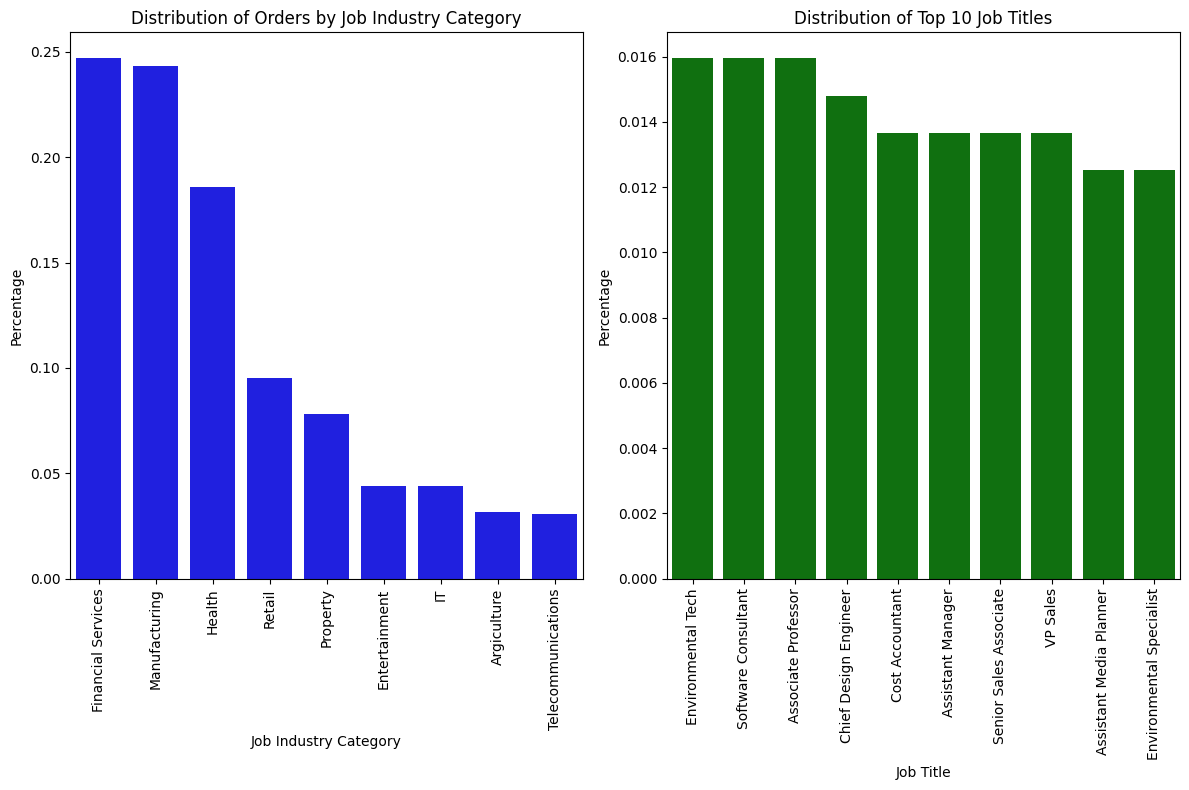

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns


plt.figure(figsize=(12, 8))

# Plotting the distribution of orders by job industry category
plt.subplot(1, 2, 1)  # 1 row, 2 columns, first plot
counts_industry = NewCustomerList['job_industry_category'].value_counts(normalize=True)
sns.barplot(x=counts_industry.index, y=counts_industry.values, color='b')
plt.xlabel('Job Industry Category')
plt.ylabel('Percentage')
plt.xticks(rotation=90)  # Rotate x-axis labels to 90 degrees
plt.title("Distribution of Orders by Job Industry Category")

# Plotting the distribution of top 10 job titles
plt.subplot(1, 2, 2)  # 1 row, 2 columns, second plot
top_10_titles = NewCustomerList['job_title'].value_counts(normalize=True).head(10)
sns.barplot(x=top_10_titles.index, y=top_10_titles.values, color='g')
plt.xlabel('Job Title')
plt.ylabel('Percentage')
plt.xticks(rotation=90)  # Rotate x-axis labels to 90 degrees
plt.title("Distribution of Top 10 Job Titles")

plt.tight_layout()  # To prevent overlapping labels and titles
plt.show()


In case of imputation I might want to put them in Manufacturing, since it is the most common value in the dataset.

In [15]:
# Dropping the null values in the job_title and job_industry_category columns
NewCustomerList = NewCustomerList.dropna(subset=['job_title', 'job_industry_category'])
analyze_null_values(NewCustomerList)

,Null Values,Total Values,Percentage of Missing Values
newcustomerlist_columns,,,
gender,0,735,0.0
past_3_years_bike_related_purchases,0,735,0.0
DOB,0,735,0.0
job_title,0,735,0.0
job_industry_category,0,735,0.0
wealth_segment,0,735,0.0
owns_car,0,735,0.0
tenure,0,735,0.0
postcode,0,735,0.0


In [16]:
# We will also drop the DOB and postcode columns as they are not required for our analysis
NewCustomerList = NewCustomerList.drop(['DOB', 'postcode'], axis=1)
required_columns = NewCustomerList.columns
print(required_columns)

Index(['gender', 'past_3_years_bike_related_purchases', 'job_title',
       'job_industry_category', 'wealth_segment', 'owns_car', 'tenure',
       'state', 'property_valuation', 'potential_customer_id', 'customer_age',
       'age_group'],
      dtype='object', name='newcustomerlist_columns')


In [17]:
NewCustomerList.info()

<class 'pandas.core.frame.DataFrame'>
Index: 735 entries, 0 to 999
Data columns (total 12 columns):
 #   Column                               Non-Null Count  Dtype   
---  ------                               --------------  -----   
 0   gender                               735 non-null    object  
 1   past_3_years_bike_related_purchases  735 non-null    int64   
 2   job_title                            735 non-null    object  
 3   job_industry_category                735 non-null    object  
 4   wealth_segment                       735 non-null    object  
 5   owns_car                             735 non-null    object  
 6   tenure                               735 non-null    int64   
 7   state                                735 non-null    object  
 8   property_valuation                   735 non-null    int64   
 9   potential_customer_id                735 non-null    int64   
 10  customer_age                         735 non-null    float64 
 11  age_group               

### The Next Steps

We now have the columns we need for the training data and the testing data, we will use one hot encoding to encode the categorical variables.

We will test the model twice, once with dropping the job_industry_category and job_title, and once with keeping them.

In [18]:
# Let all_data be the required columns from the Reference dataframe
all_data = Reference[['gender', 'past_3_years_bike_related_purchases', 'job_title',
       'job_industry_category', 'wealth_segment', 'owns_car', 'tenure',
       'state', 'property_valuation', 'customer_age','customer_category',
       'age_group']]



# 2. Building the Model

In [20]:
import pandas as pd

data = all_data.copy()
data

reference_columns,gender,past_3_years_bike_related_purchases,job_title,job_industry_category,wealth_segment,owns_car,tenure,state,property_valuation,customer_age,customer_category,age_group
0,F,93,Executive Secretary,Health,Mass Customer,True,11,NSW,10,64,Gold,51-70
1,F,93,Executive Secretary,Health,Mass Customer,True,11,NSW,10,64,Gold,51-70
2,F,93,Executive Secretary,Health,Mass Customer,True,11,NSW,10,64,Gold,51-70
3,F,93,Executive Secretary,Health,Mass Customer,True,11,NSW,10,64,Gold,51-70
4,F,93,Executive Secretary,Health,Mass Customer,True,11,NSW,10,64,Gold,51-70
...,...,...,...,...,...,...,...,...,...,...,...,...
17010,M,99,Editor,Manufacturing,Mass Customer,True,19,NSW,9,31,Bronze,31-50
17011,M,99,Editor,Manufacturing,Mass Customer,True,19,NSW,9,31,Bronze,31-50
17012,F,73,Administrative Assistant IV,Manufacturing,Affluent Customer,True,18,VIC,5,31,Silver,31-50
17013,F,73,Administrative Assistant IV,Manufacturing,Affluent Customer,True,18,VIC,5,31,Silver,31-50
